In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [3]:
train_datasets = [
    'train_val_data_pca-9.csv', 
    'train_val_data_pca-7.csv', 
    'train_val_data_pca-5.csv', 
    'train_val_data.csv'
]

test_datasets = [
    'test_data_pca-9.csv',
    'test_data_pca-7.csv', 
    'test_data_pca-5.csv', 
    'test_data.csv'
]

param_grid = {
    'n_estimators': [150, 175, 200, 225, 250],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

results = {}


In [5]:
# 五折交叉验证

train_data_pca9 = pd.read_csv(f'dataset6/{train_datasets[0]}')
X_train_pca9 = train_data_pca9.drop('quality', axis=1)
y_train_pca9 = train_data_pca9['quality']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train_pca9, y_train_pca9)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [150, 175, 200, 225, 250]},
             scoring='accuracy')

In [35]:
cv_results = rf_grid.cv_results_
n_estimators_values = [params['n_estimators'] for params in cv_results['params']]
unique_n_estimators = sorted(set(n_estimators_values))

mean_scores = []
for n_est in unique_n_estimators:
    mask = [params['n_estimators'] == n_est for params in cv_results['params']]
    mean_acc = np.mean(cv_results['mean_test_score'][mask])
    mean_scores.append(mean_acc)

print("不同超参数的平均准确率：")
for n_est, acc in zip(unique_n_estimators, mean_scores):
    print(f"n_estimators={n_est}: 平均准确率={acc:.4f}")

# 找出最高平均准确率对应的 n_estimators
best_n_est_index = np.argmax(mean_scores)
best_n_est_from_bar = unique_n_estimators[best_n_est_index]
print(f"\n柱状图中最高平均准确率对应的n_estimators={best_n_est_from_bar}, 准确率={mean_scores[best_n_est_index]:.4f}")

不同超参数的平均准确率：
n_estimators=150: 平均准确率=0.8959
n_estimators=175: 平均准确率=0.8962
n_estimators=200: 平均准确率=0.8966
n_estimators=225: 平均准确率=0.8959
n_estimators=250: 平均准确率=0.8946

柱状图中最高平均准确率对应的n_estimators=200, 准确率=0.8966


C:\Users\10940\AppData\Local\Temp\ipykernel_11468\1126308933.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='n_estimators', data=hyper_parameter_optimze_frame, palette=colorlist, edgecolor='#DDDDDD')


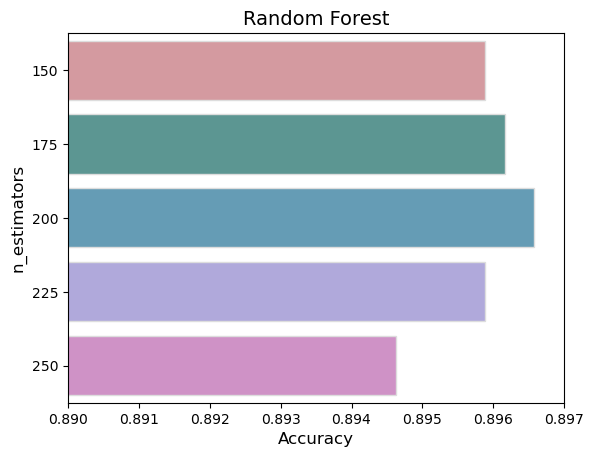

In [29]:
# 使用Seaborn的barplot绘制横向柱状图
import seaborn as sns

n_estimators_list = [str(x) for x in unique_n_estimators]
accuracy_values = mean_scores

hyper_parameter_optimze = {
    'n_estimators': n_estimators_list,
    'Accuracy': accuracy_values
}
hyper_parameter_optimze_frame = pd.DataFrame(hyper_parameter_optimze)

colorlist = ['#de9099', '#539f9a', '#57a1c3', '#aaa1e3', '#d988cd']

sns.barplot(x='Accuracy', y='n_estimators', data=hyper_parameter_optimze_frame, palette=colorlist, edgecolor='#DDDDDD')

plt.xlim(0.8900, 0.8970)
plt.title("Random Forest", fontsize=14)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("n_estimators", fontsize=12)

plt.show()

In [23]:
best_params = rf_grid.best_params_.copy()
best_params['n_estimators'] = 200
custom_rf = RandomForestClassifier(**best_params, random_state=42)

# 对pca-9、pca-7、pca-5以及no pca(ram)数据集进行评估

for train_name, test_name in zip(train_datasets, test_datasets):

    train_data = pd.read_csv(f'dataset6/{train_name}')
    test_data = pd.read_csv(f'dataset6/{test_name}')
    X_train = train_data.drop('quality', axis=1)
    y_train = train_data['quality']
    X_test = test_data.drop('quality', axis=1)
    y_test = test_data['quality']
    
    custom_rf.fit(X_train, y_train)
    y_pred = custom_rf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)
    
    results[train_name] = {
        'accuracy': accuracy,
        'classification_report': clf_report
    }

print("\n使用 n_estimators=200 的随机森林分类结果:")
for dataset, result in results.items():
    print(f"\n数据集: {dataset}")
    print(f"准确率: {result['accuracy']:.4f}")
    print("分类报告:")
    print(result['classification_report'])


使用 n_estimators=200 的随机森林分类结果:

数据集: train_val_data_pca-9.csv
准确率: 0.9110
分类报告:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       252
           1       0.72      0.57      0.64        40

    accuracy                           0.91       292
   macro avg       0.83      0.77      0.79       292
weighted avg       0.91      0.91      0.91       292


数据集: train_val_data_pca-7.csv
准确率: 0.9041
分类报告:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       252
           1       0.70      0.53      0.60        40

    accuracy                           0.90       292
   macro avg       0.81      0.74      0.77       292
weighted avg       0.90      0.90      0.90       292


数据集: train_val_data_pca-5.csv
准确率: 0.8459
分类报告:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       252
           1       0.22      0.05      0.08        40

   

C:\Users\10940\AppData\Local\Temp\ipykernel_11468\2496371174.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy',


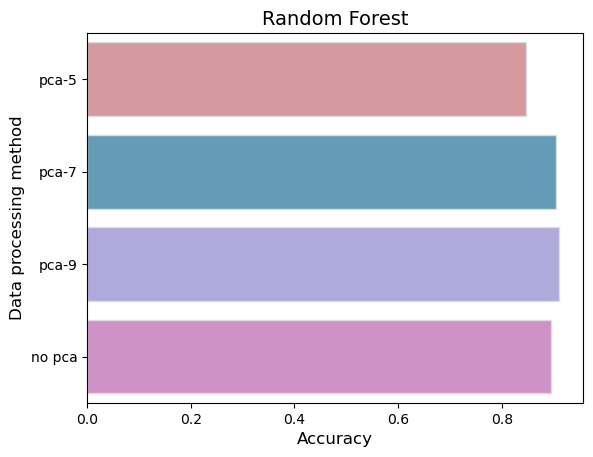

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

processing_list = ['pca-5', 'pca-7', 'pca-9', 'no pca']
accuracy_list = [results[mapping[m]]['accuracy'] for m in processing_list]

hyper_parameter_optimze = {
    'Data processing method': processing_list,
    'Accuracy': accuracy_list
}
hyper_parameter_optimze_frame = pd.DataFrame(hyper_parameter_optimze)

colorlist = ['#de9099', '#57a1c3', '#aaa1e3', '#d988cd']

sns.barplot(x='Accuracy', 
            y='Data processing method', 
            data=hyper_parameter_optimze_frame, 
            palette=colorlist, 
            edgecolor='#DDDDDD')

plt.title("Random Forest", fontsize=14)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Data processing method", fontsize=12)

plt.show()
